# 21110308 - Trương Quốc Huy - IS - Lab06

In [ ]:
%pip install roboflow ultralytics==8.0.196 --quiet

## Question 1

In [2]:
!nvidia-smi

Wed Jul 31 06:23:30 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P0             25W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
from roboflow import Roboflow
from ultralytics import YOLO
from IPython.display import Image
from pathlib import Path
from typing import Dict, List, Tuple
from json import JSONEncoder
import wandb
import ultralytics
import os
import json
import shutil
import numpy as np

In [4]:
ultralytics.checks()

Ultralytics YOLOv8.0.196 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 5771.7/8062.4 GB disk)


In [5]:
images = [Path("./ListImage/")/image 
          for image in os.listdir("./ListImage")]
images

[PosixPath('/kaggle/input/is-lab06-question1/ListImage/people_walk_0.png'),
 PosixPath('/kaggle/input/is-lab06-question1/ListImage/people_dog_walk.jpeg')]

In [6]:
model = YOLO("yolov8s-seg.pt")
results = model.predict(source=images, conf=0.25, save=True)

100%|██████████| 22.8M/22.8M [00:00<00:00, 164MB/s]

0: 640x640 3 persons, 1: 640x640 5 persons, 1 dog, 97.4ms
Speed: 10.7ms preprocess, 48.7ms inference, 136.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/segment/predict


In [7]:
show_predict_images = [
    Image(f'./runs/segment/predict/{predict_image}')
    for predict_image in os.listdir("./runs/segment/predict")
]

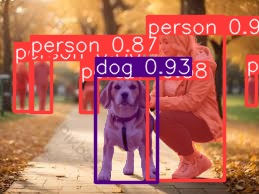

In [8]:
show_predict_images[0]

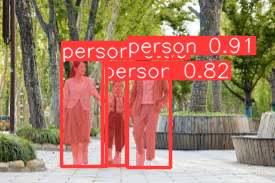

In [9]:
show_predict_images[-1]

In [10]:
def convert_boxes(box: ultralytics.engine.results.Boxes) -> Dict:
    box = box.cpu().numpy()
    return {
        "cls": box.cls,
        "conf": box.conf,
        "data": box.data,
        "xywh": box.xywh,
        "xywhn": box.xywhn,
        "xyxy": box.xyxy,
        "xyxyn": box.xyxyn
    }

def convert_masks(mask: ultralytics.engine.results.Masks) -> Dict:
    mask = mask.cpu()
    return_dict = {"xy": mask.xy, "xyn": mask.xyn}
    mask_np = mask.numpy()
    return_dict['data'] = mask_np.data
    return return_dict

In [11]:
class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

In [12]:
result_dir = Path('./results')
for result, orig_img_path in zip(results, images):
    result_path = result_dir / orig_img_path.name.split('.')[0]

    os.makedirs(str(result_path), exist_ok=True)
    shutil.copy(orig_img_path, str(result_path / orig_img_path.name))
    
    with open(str(result_path / orig_img_path.name.split('.')[0]) + '.json', 'w', encoding='utf8') as json_file:
        json.dump(
            {
                "save_dir": result.save_dir, 
                "boxes": convert_boxes(result.boxes), 
                "maskes": convert_masks(result.masks)
            },
            json_file,
            ensure_ascii=False,
            cls=NumpyArrayEncoder
        )
        print(f'Create {json_file.name} file')

Create /kaggle/working/results/people_walk_0/people_walk_0.json file
Create /kaggle/working/results/people_dog_walk/people_dog_walk.json file


## Question 2

In [13]:
rf = Roboflow(api_key="xzCd0k5C30C3fIcLqJ1R")

In [14]:
project_0 = rf.workspace("alpaco5-f3woi")\
            .project("part-autolabeld")
dataset_0 = project_0.version(5)\
            .download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to part-autolabeld-5 in yolov8:: 100%|██████████| 18890/18890 [00:03<00:00, 4894.00it/s]


In [15]:
!yolo task=segment \
    mode=train \
    model=yolov8s-seg.pt \
    data={dataset_0.location}/data.yaml \
    epochs=10 \
    imgsz=640

New https://pypi.org/project/ultralytics/8.2.70 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.196 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=yolov8s-seg.pt, data=/kaggle/working/part-autolabeld-5/data.yaml, epochs=10, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visuali

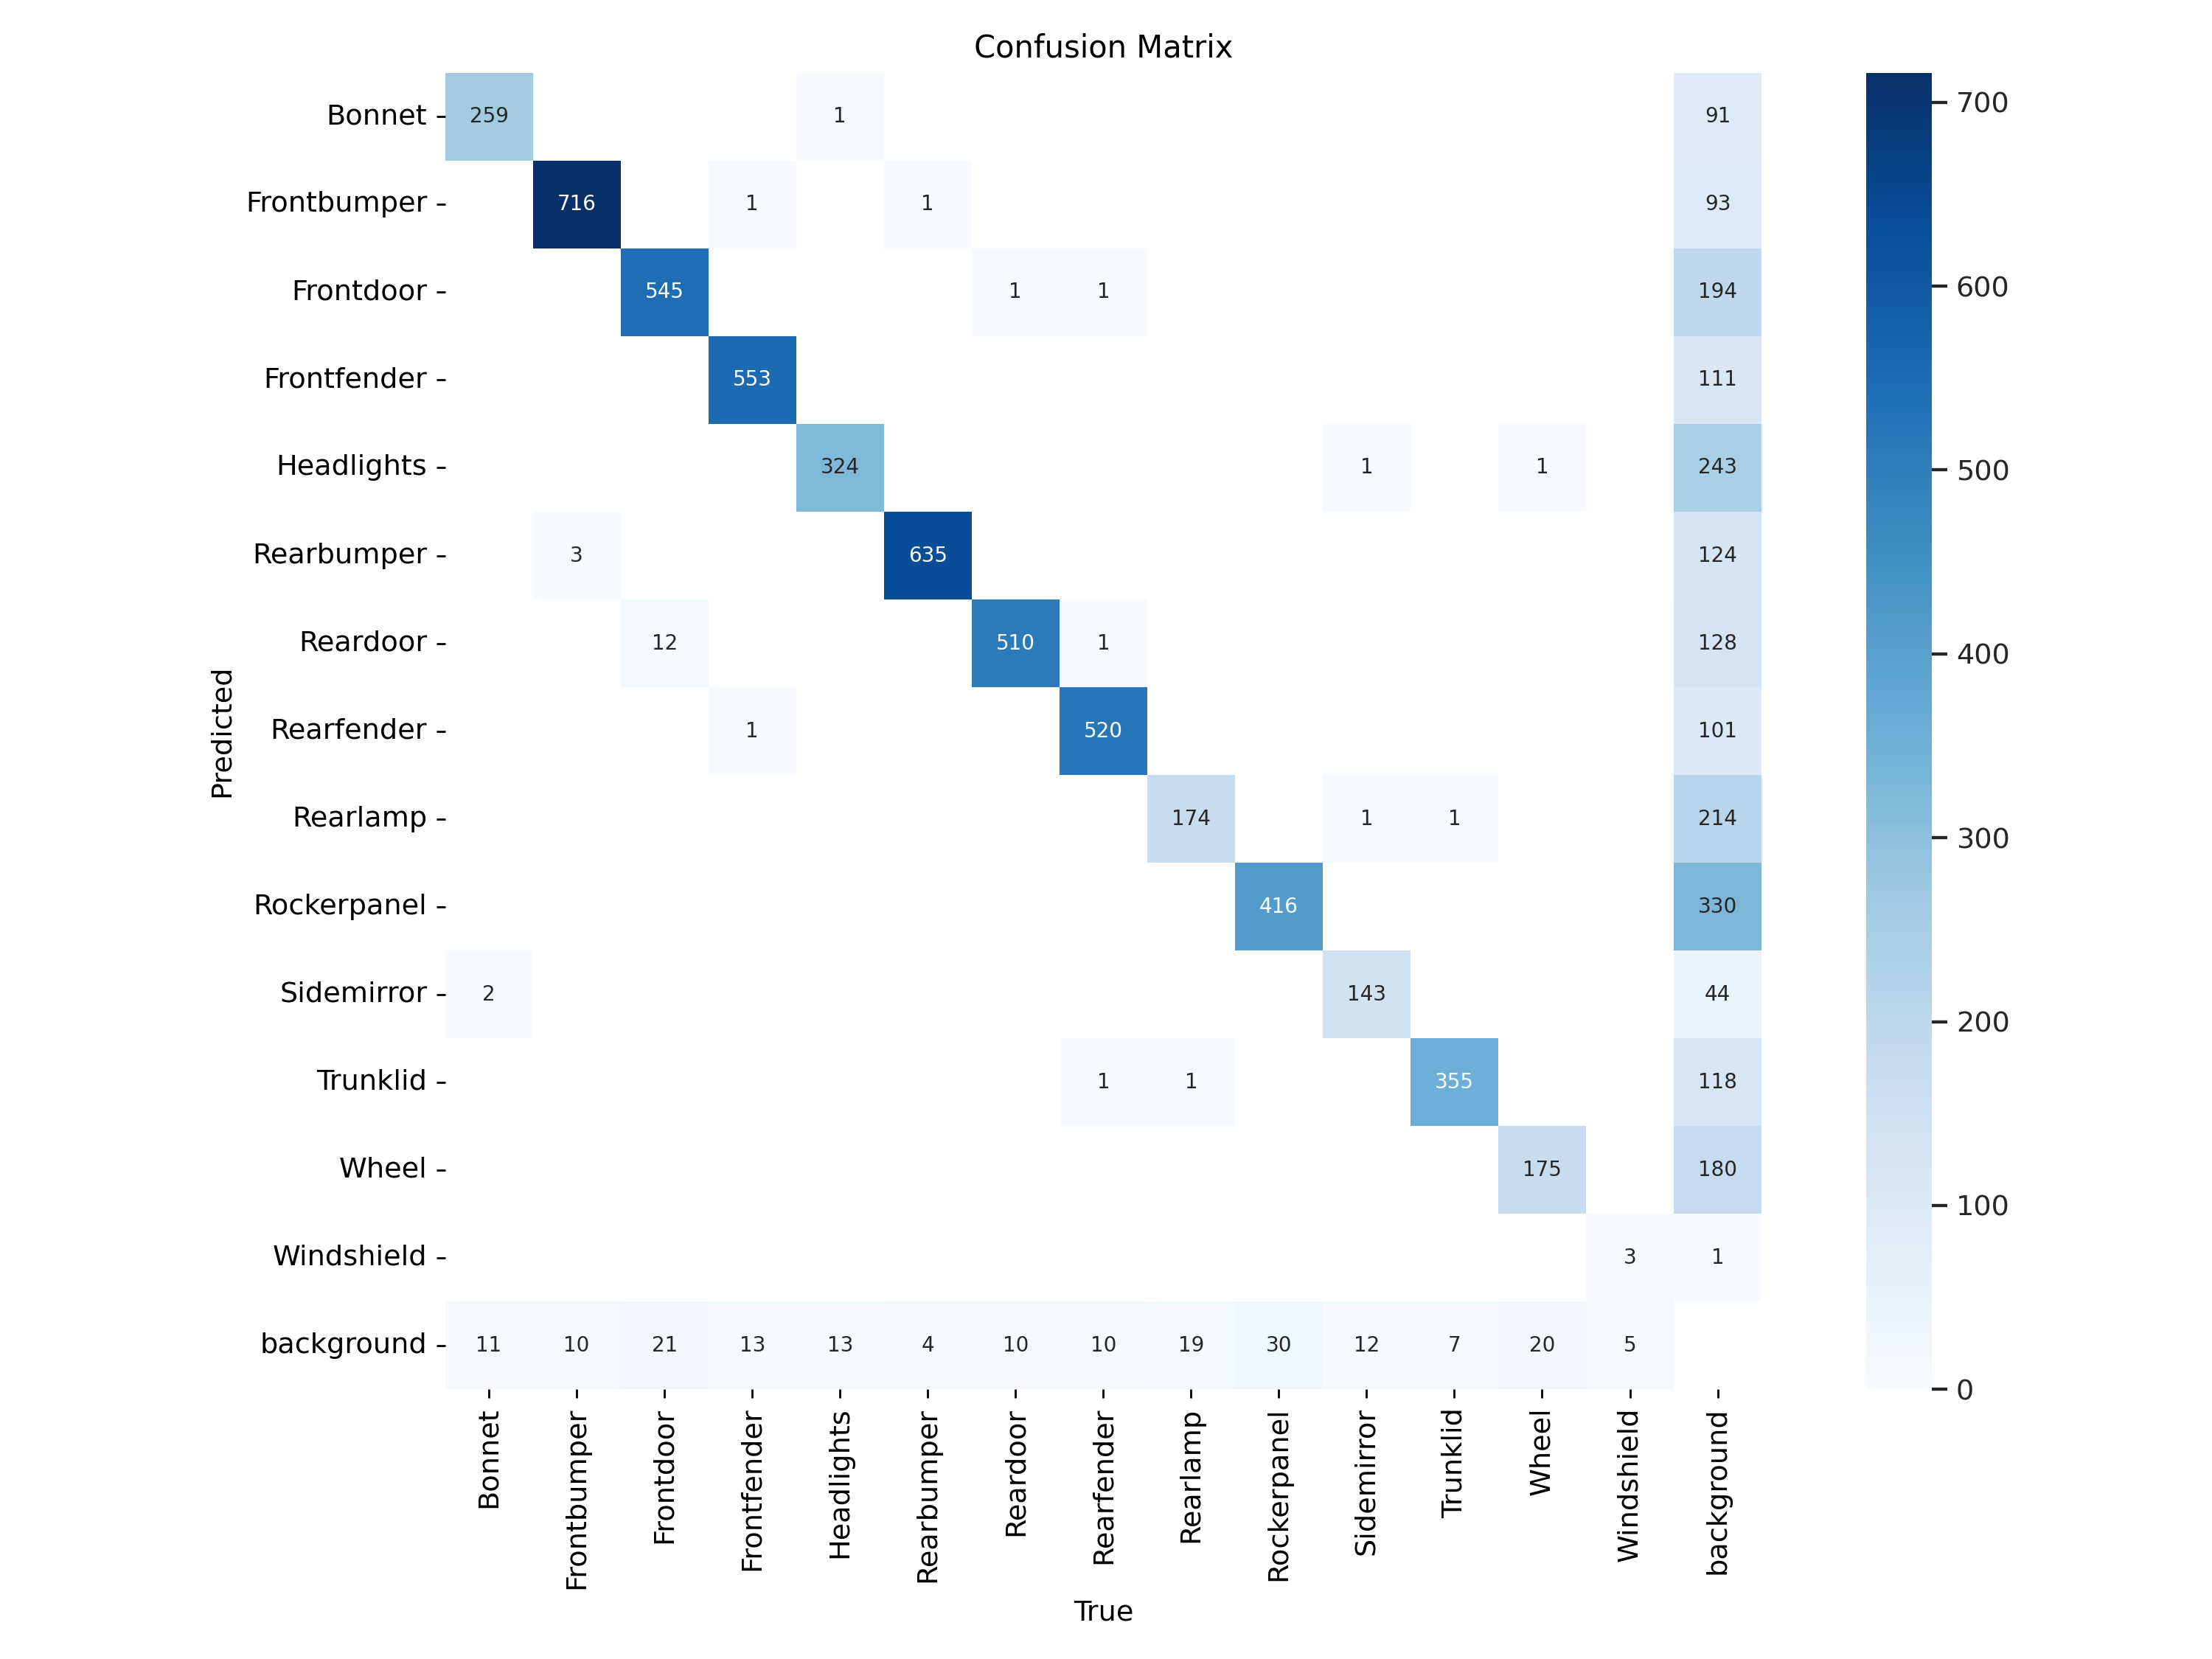

In [16]:
Image(filename=f'./runs/segment/train/confusion_matrix.png', 
      width=600)

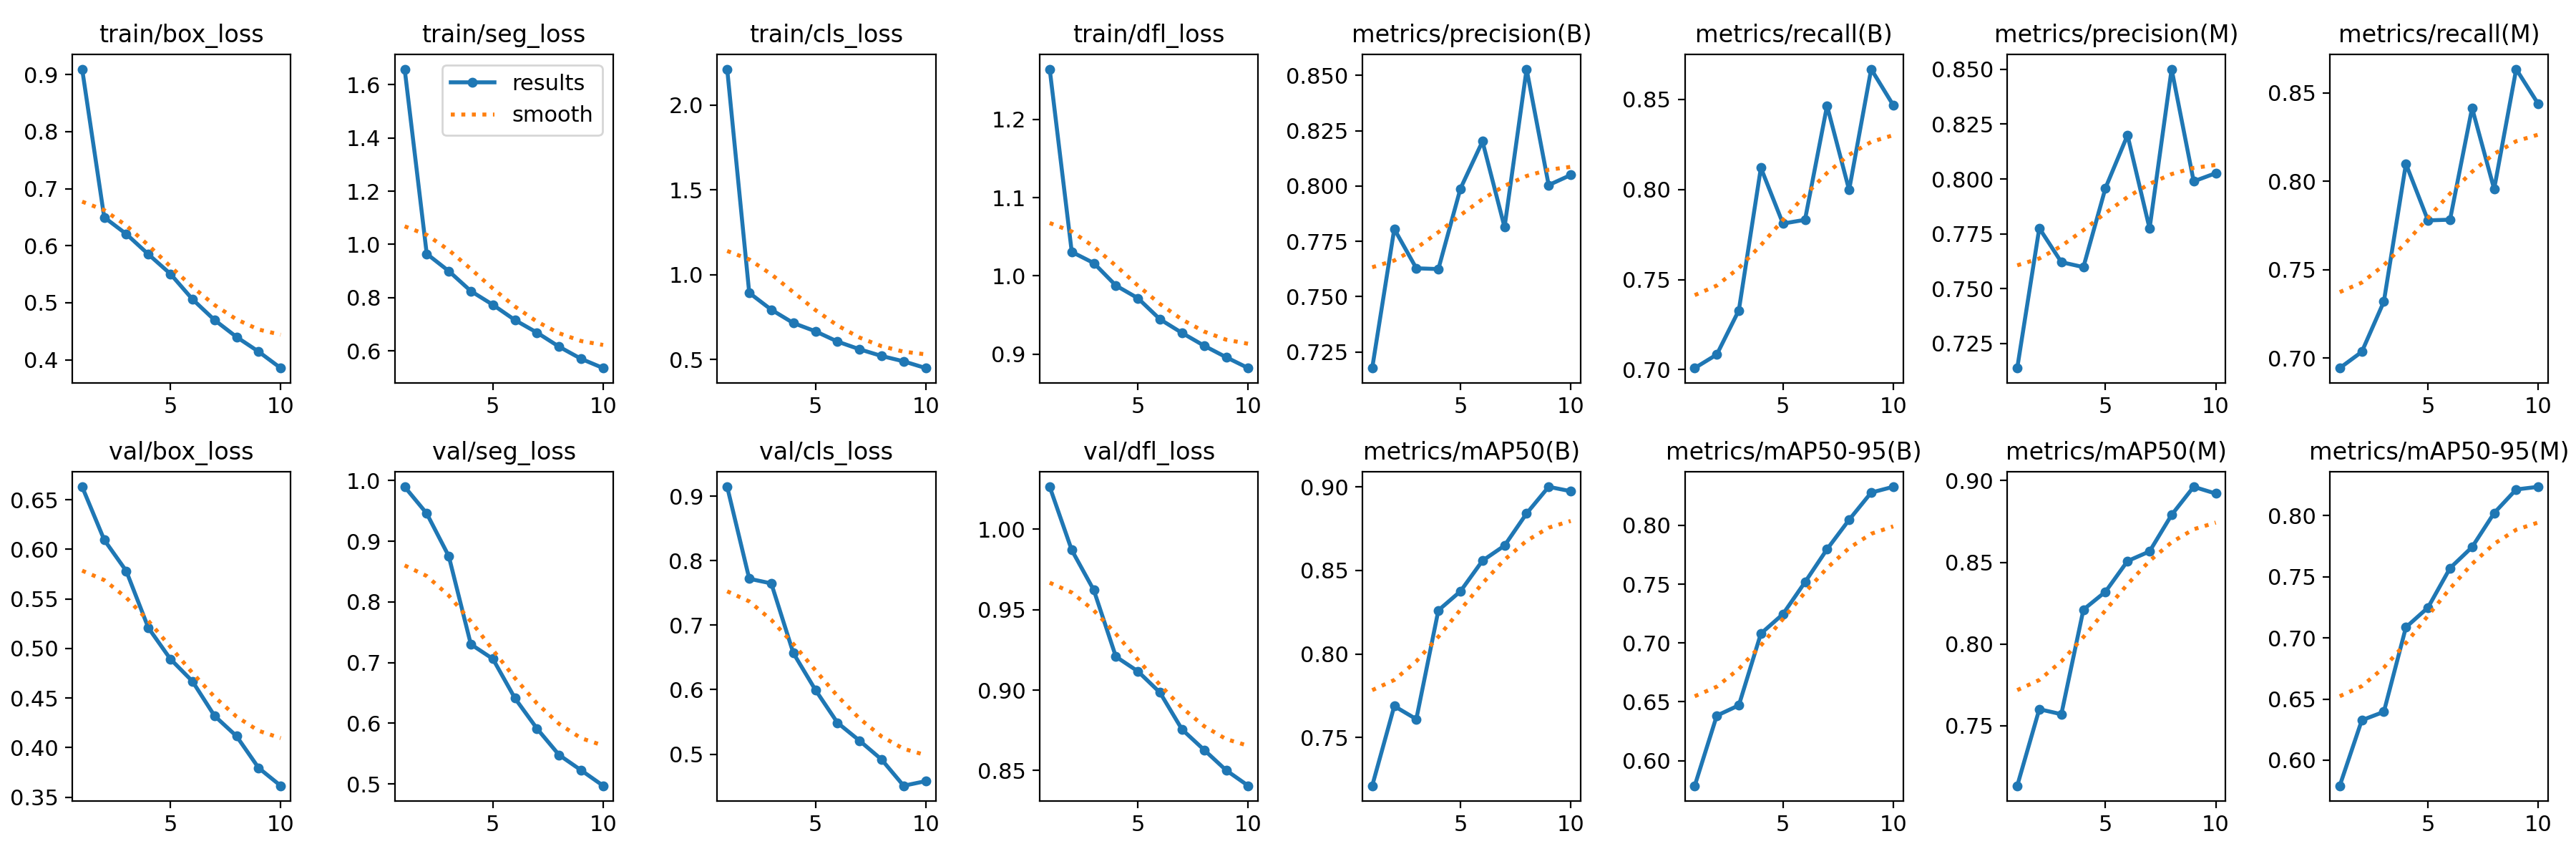

In [17]:
Image(filename=f'./runs/segment/train/results.png', width=600)

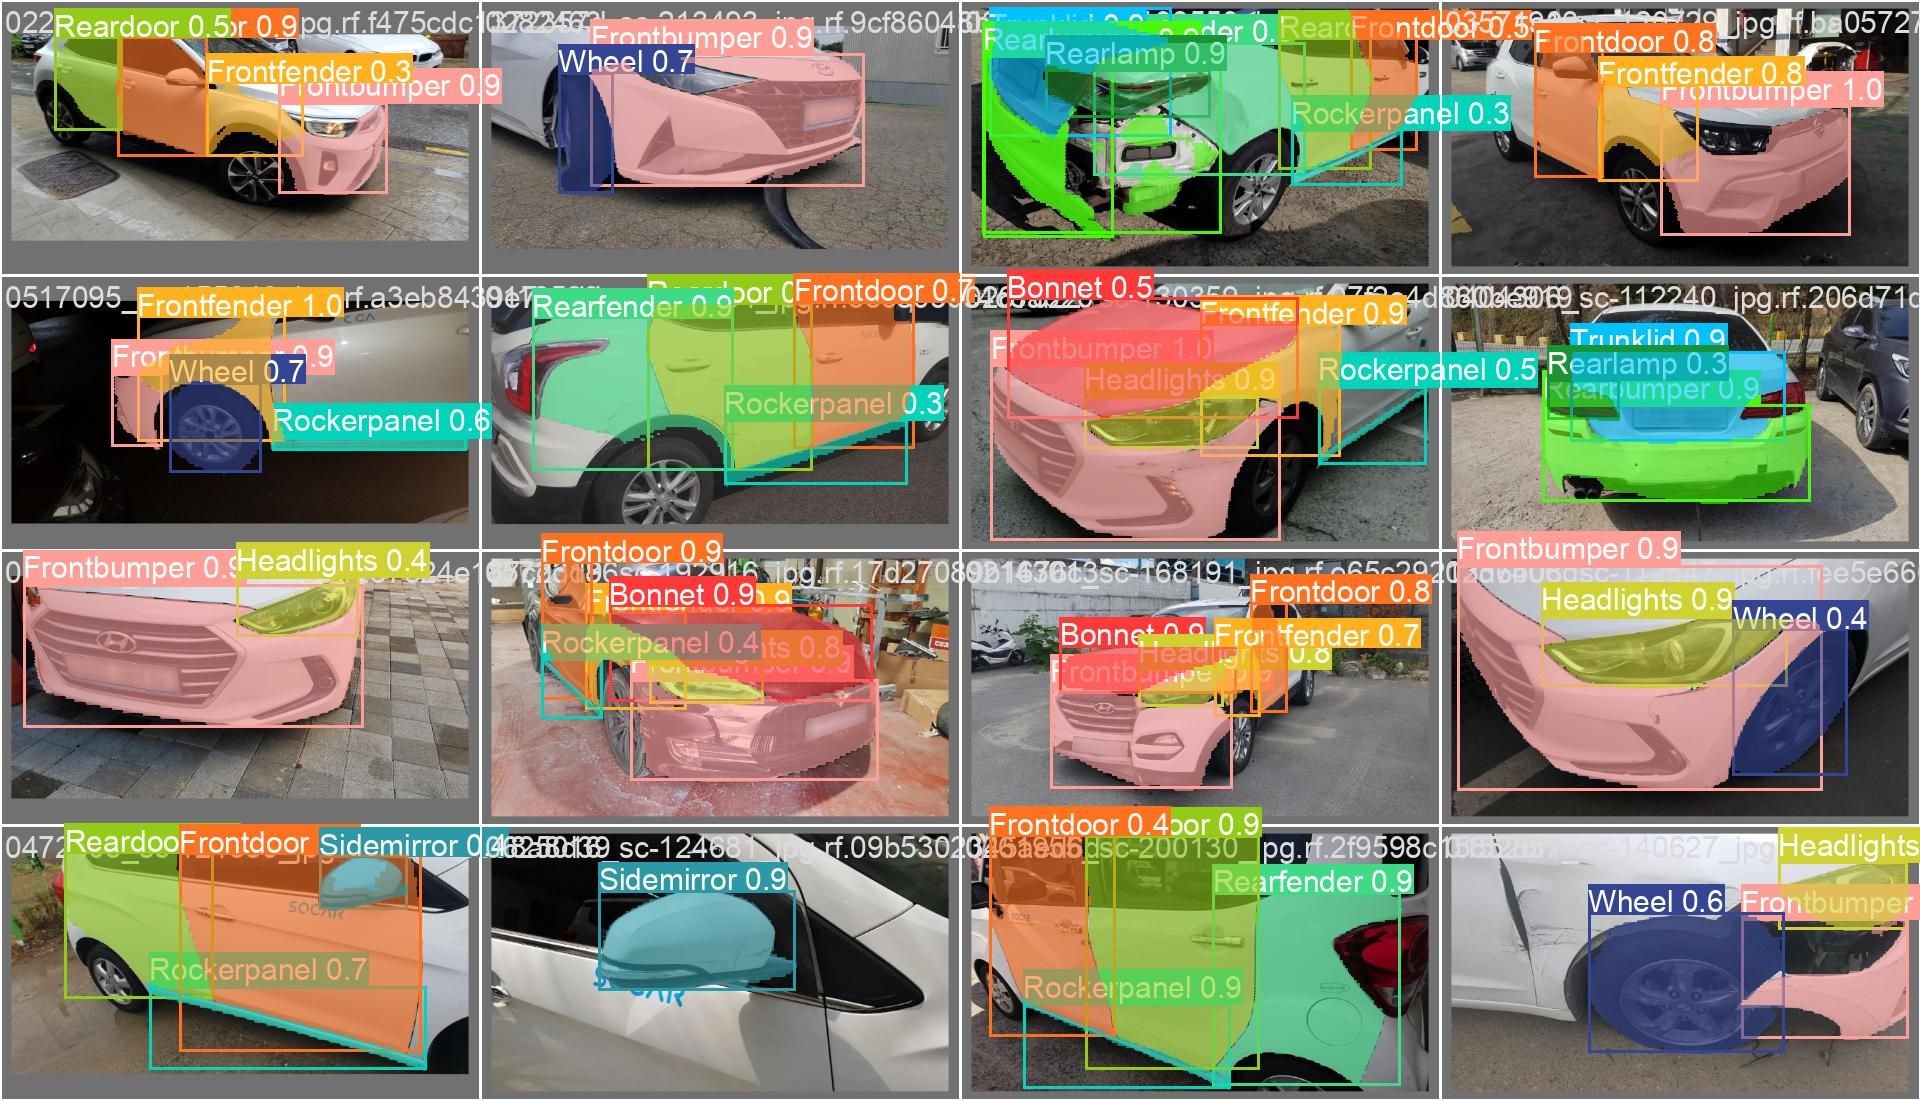

In [18]:
Image(filename=f'./runs/segment/train/val_batch0_pred.jpg', width=600)

## Question 3

In [19]:
project = rf.workspace("segmenting-rooms").project("room-segment-3zyl5")
version = project.version(2)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Room-Segment-2 in yolov8:: 100%|██████████| 21810/21810 [00:03<00:00, 6944.86it/s]


In [20]:
!yolo task=segment \
    mode=train \
    model=yolov8s-seg.pt \
    data={dataset.location}/data.yaml \
    epochs=10 \
    imgsz=640

New https://pypi.org/project/ultralytics/8.2.70 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.196 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=yolov8s-seg.pt, data=/kaggle/working/Room-Segment-2/data.yaml, epochs=10, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=

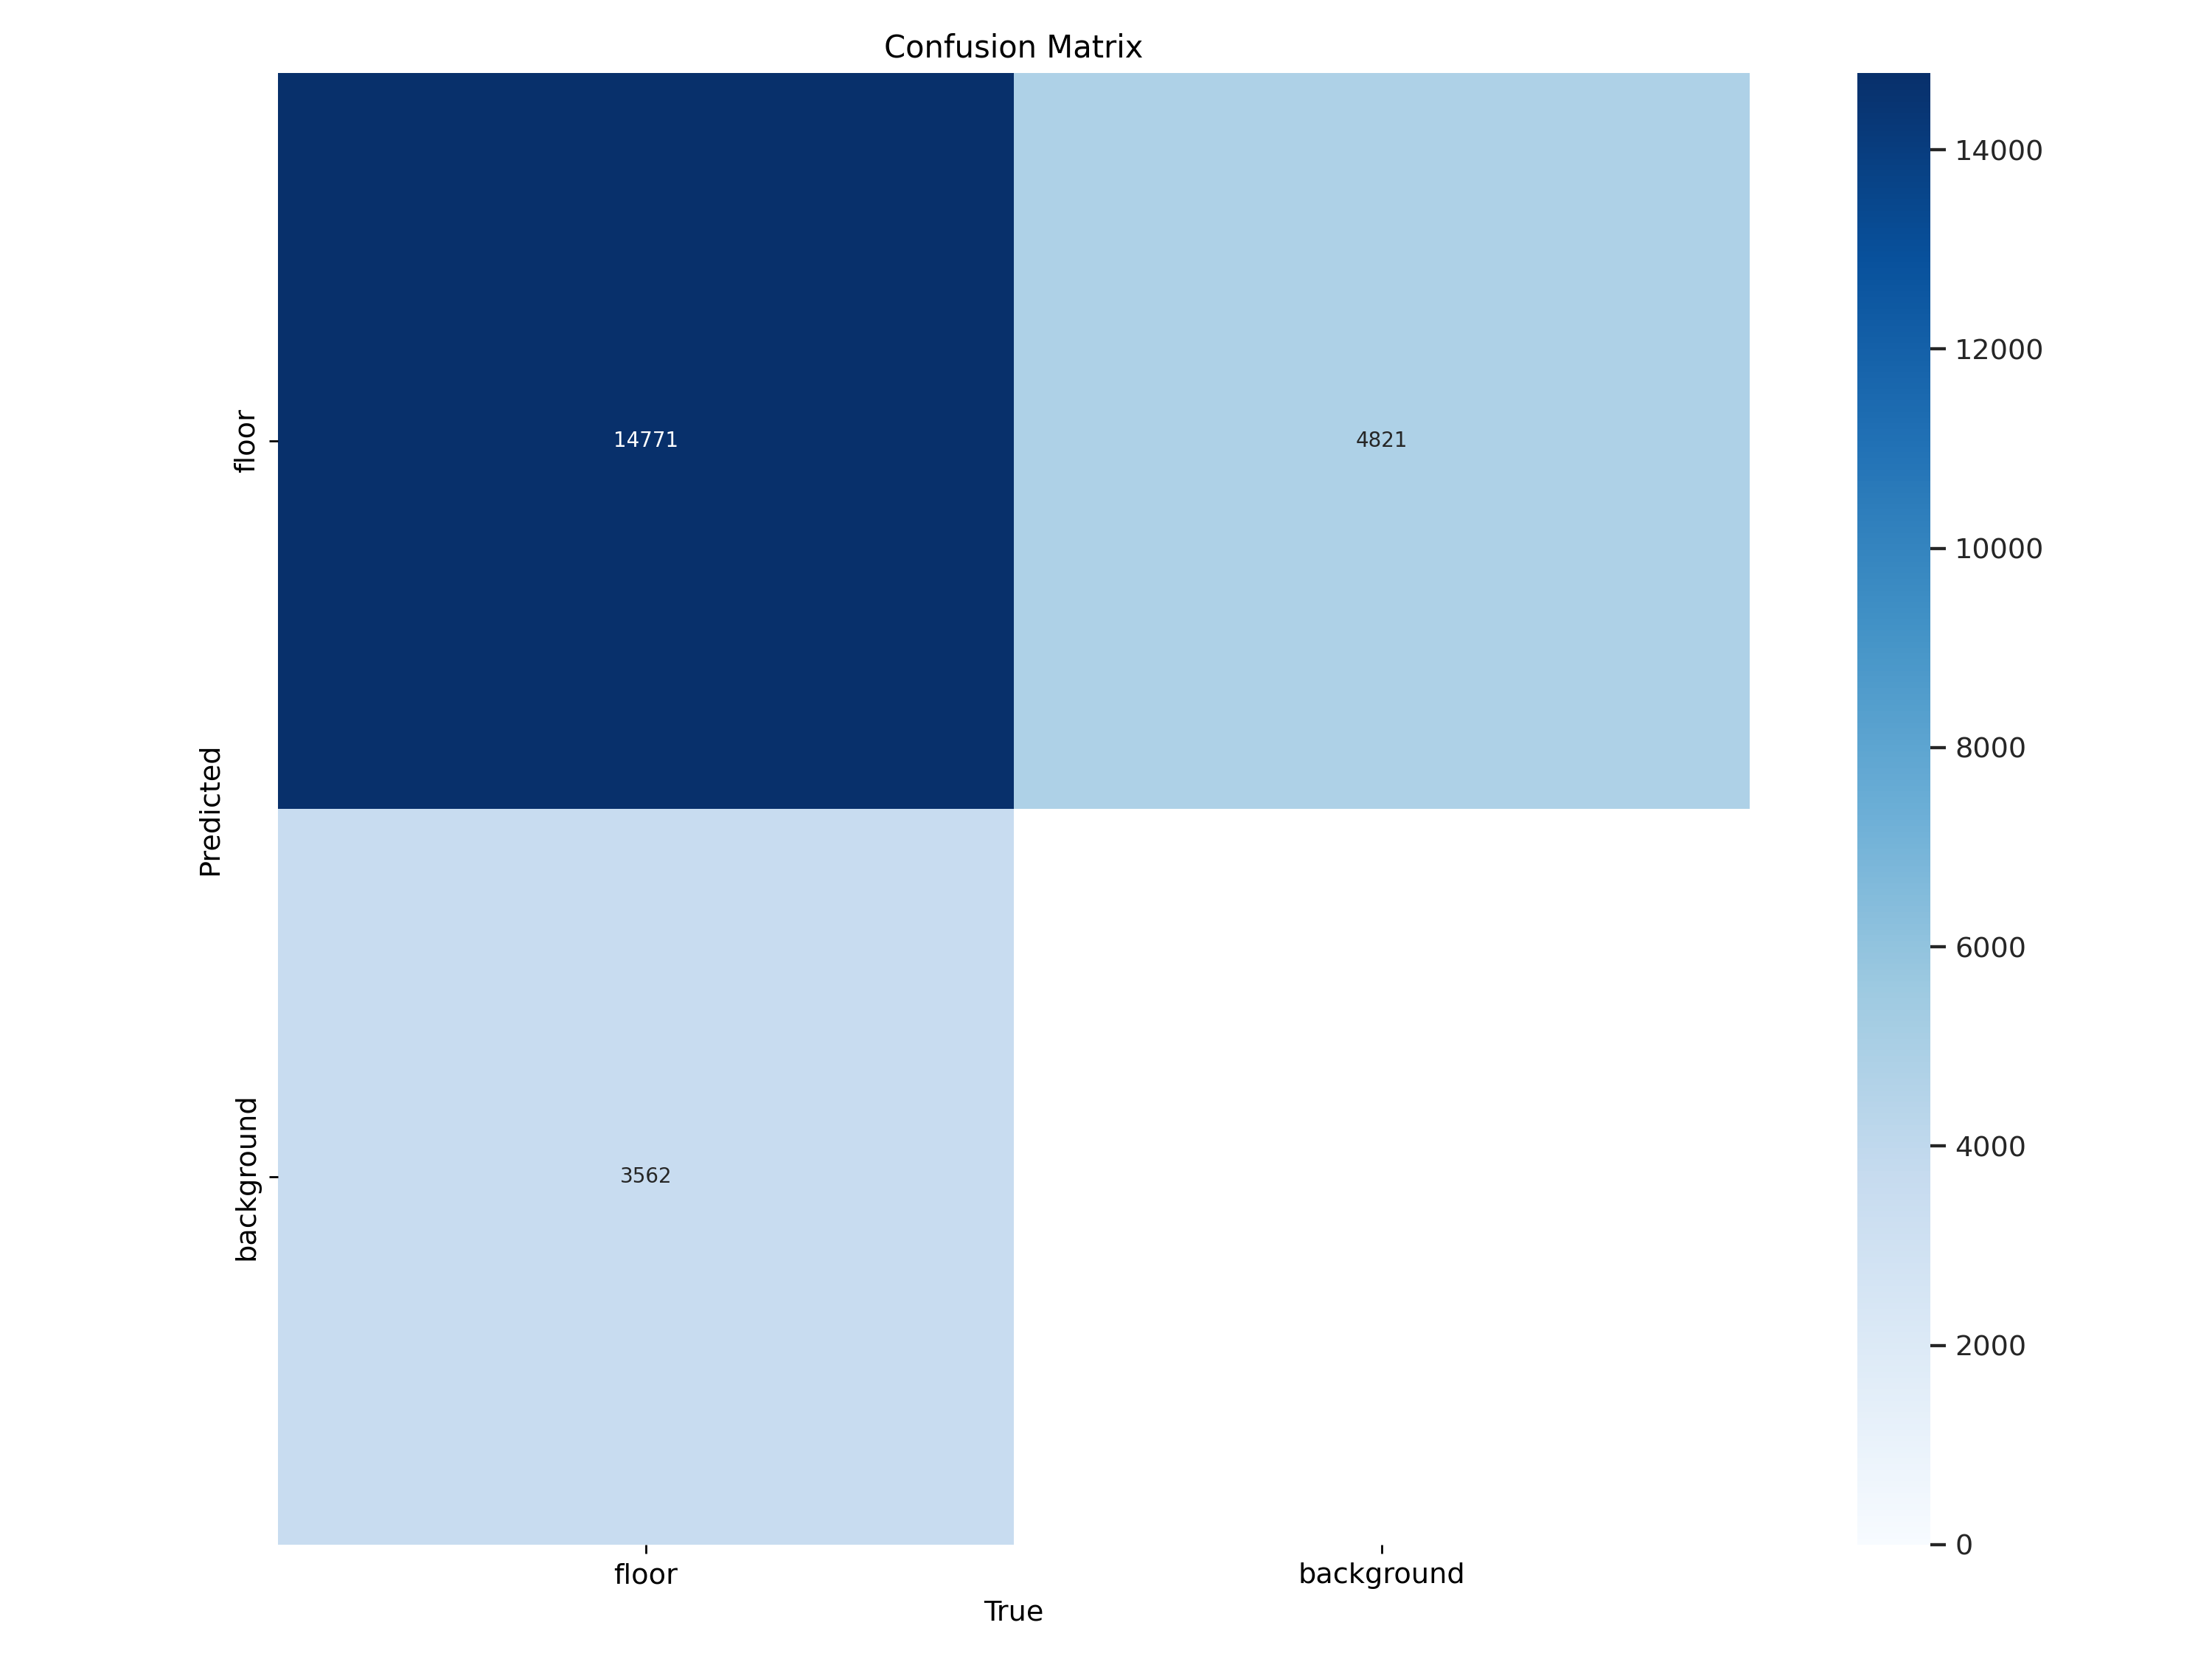

In [21]:
Image(filename=f'./runs/segment/train2/confusion_matrix.png', 
      width=600)

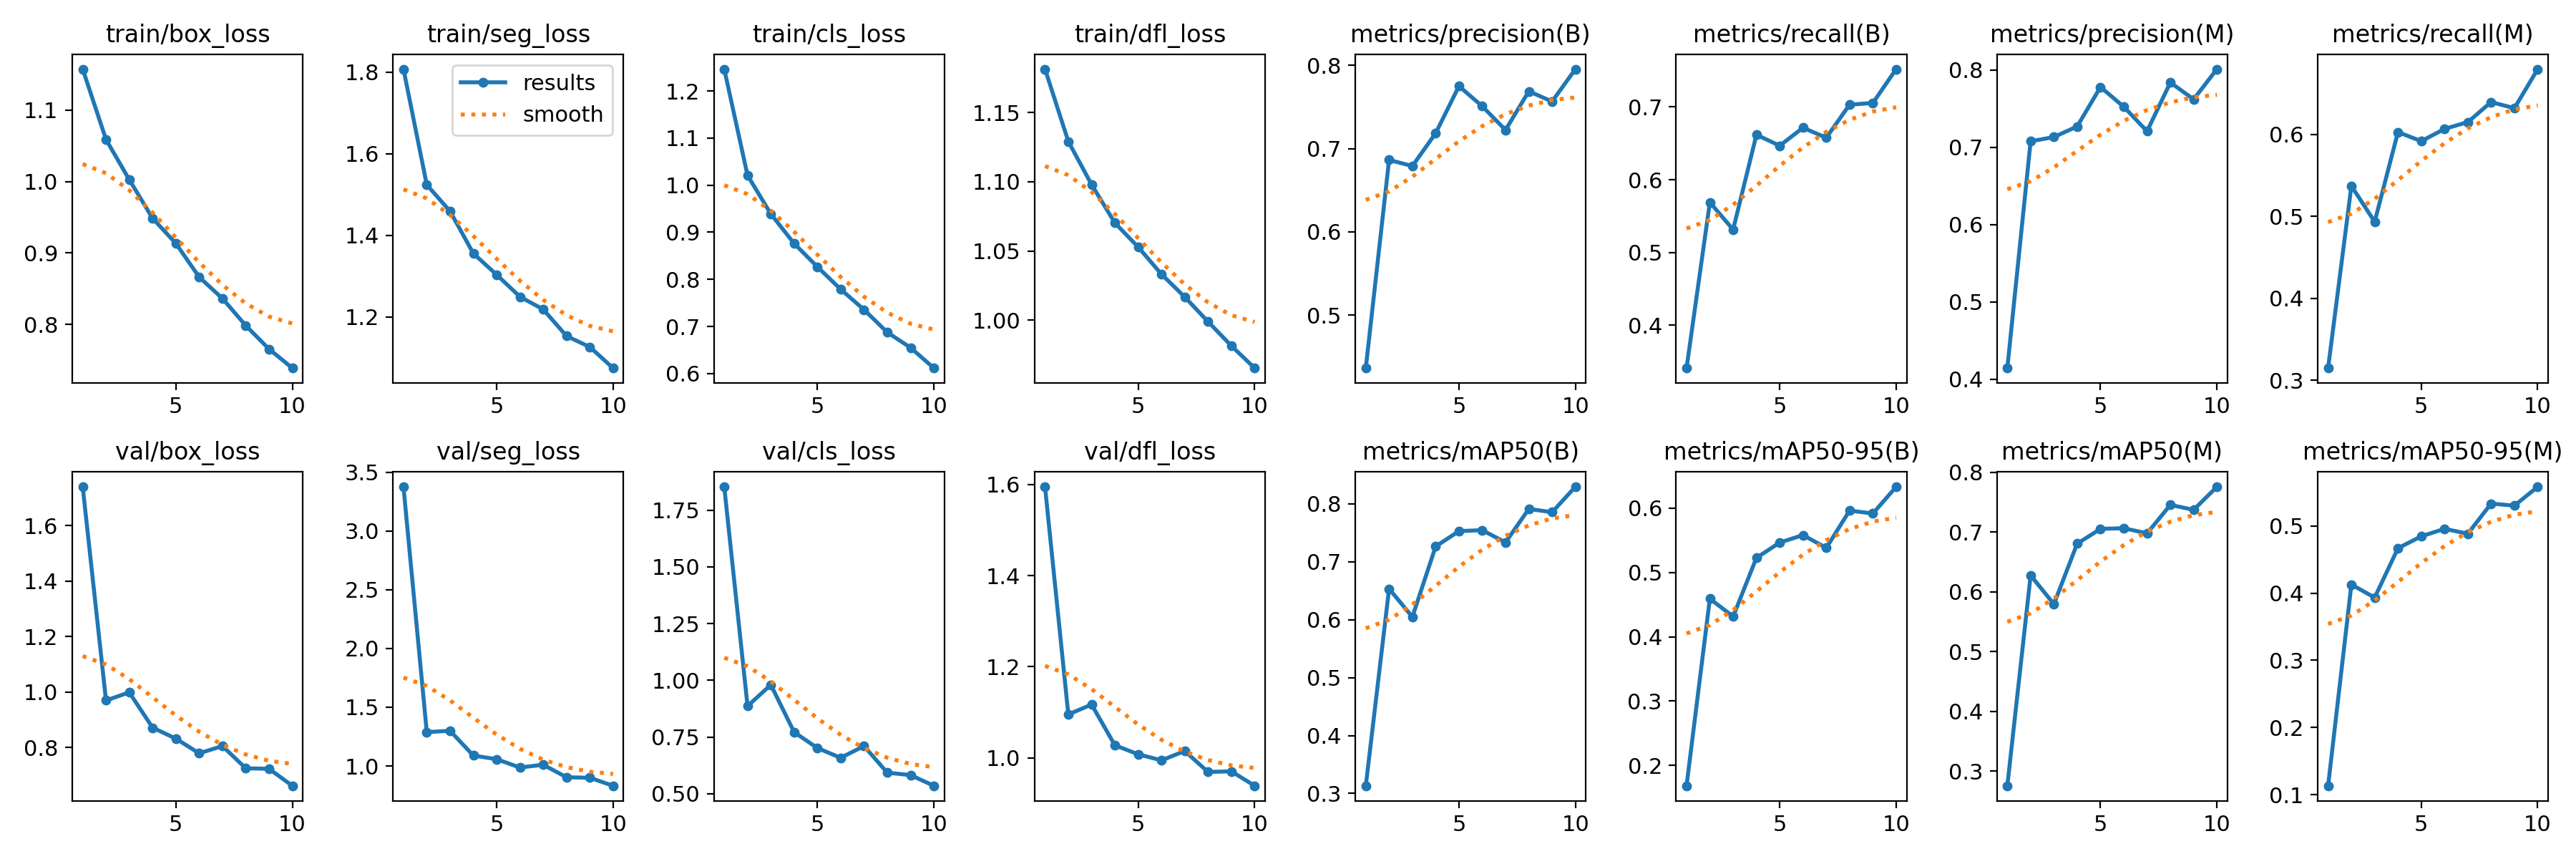

In [22]:
Image(filename=f'./runs/segment/train2/results.png', width=600)

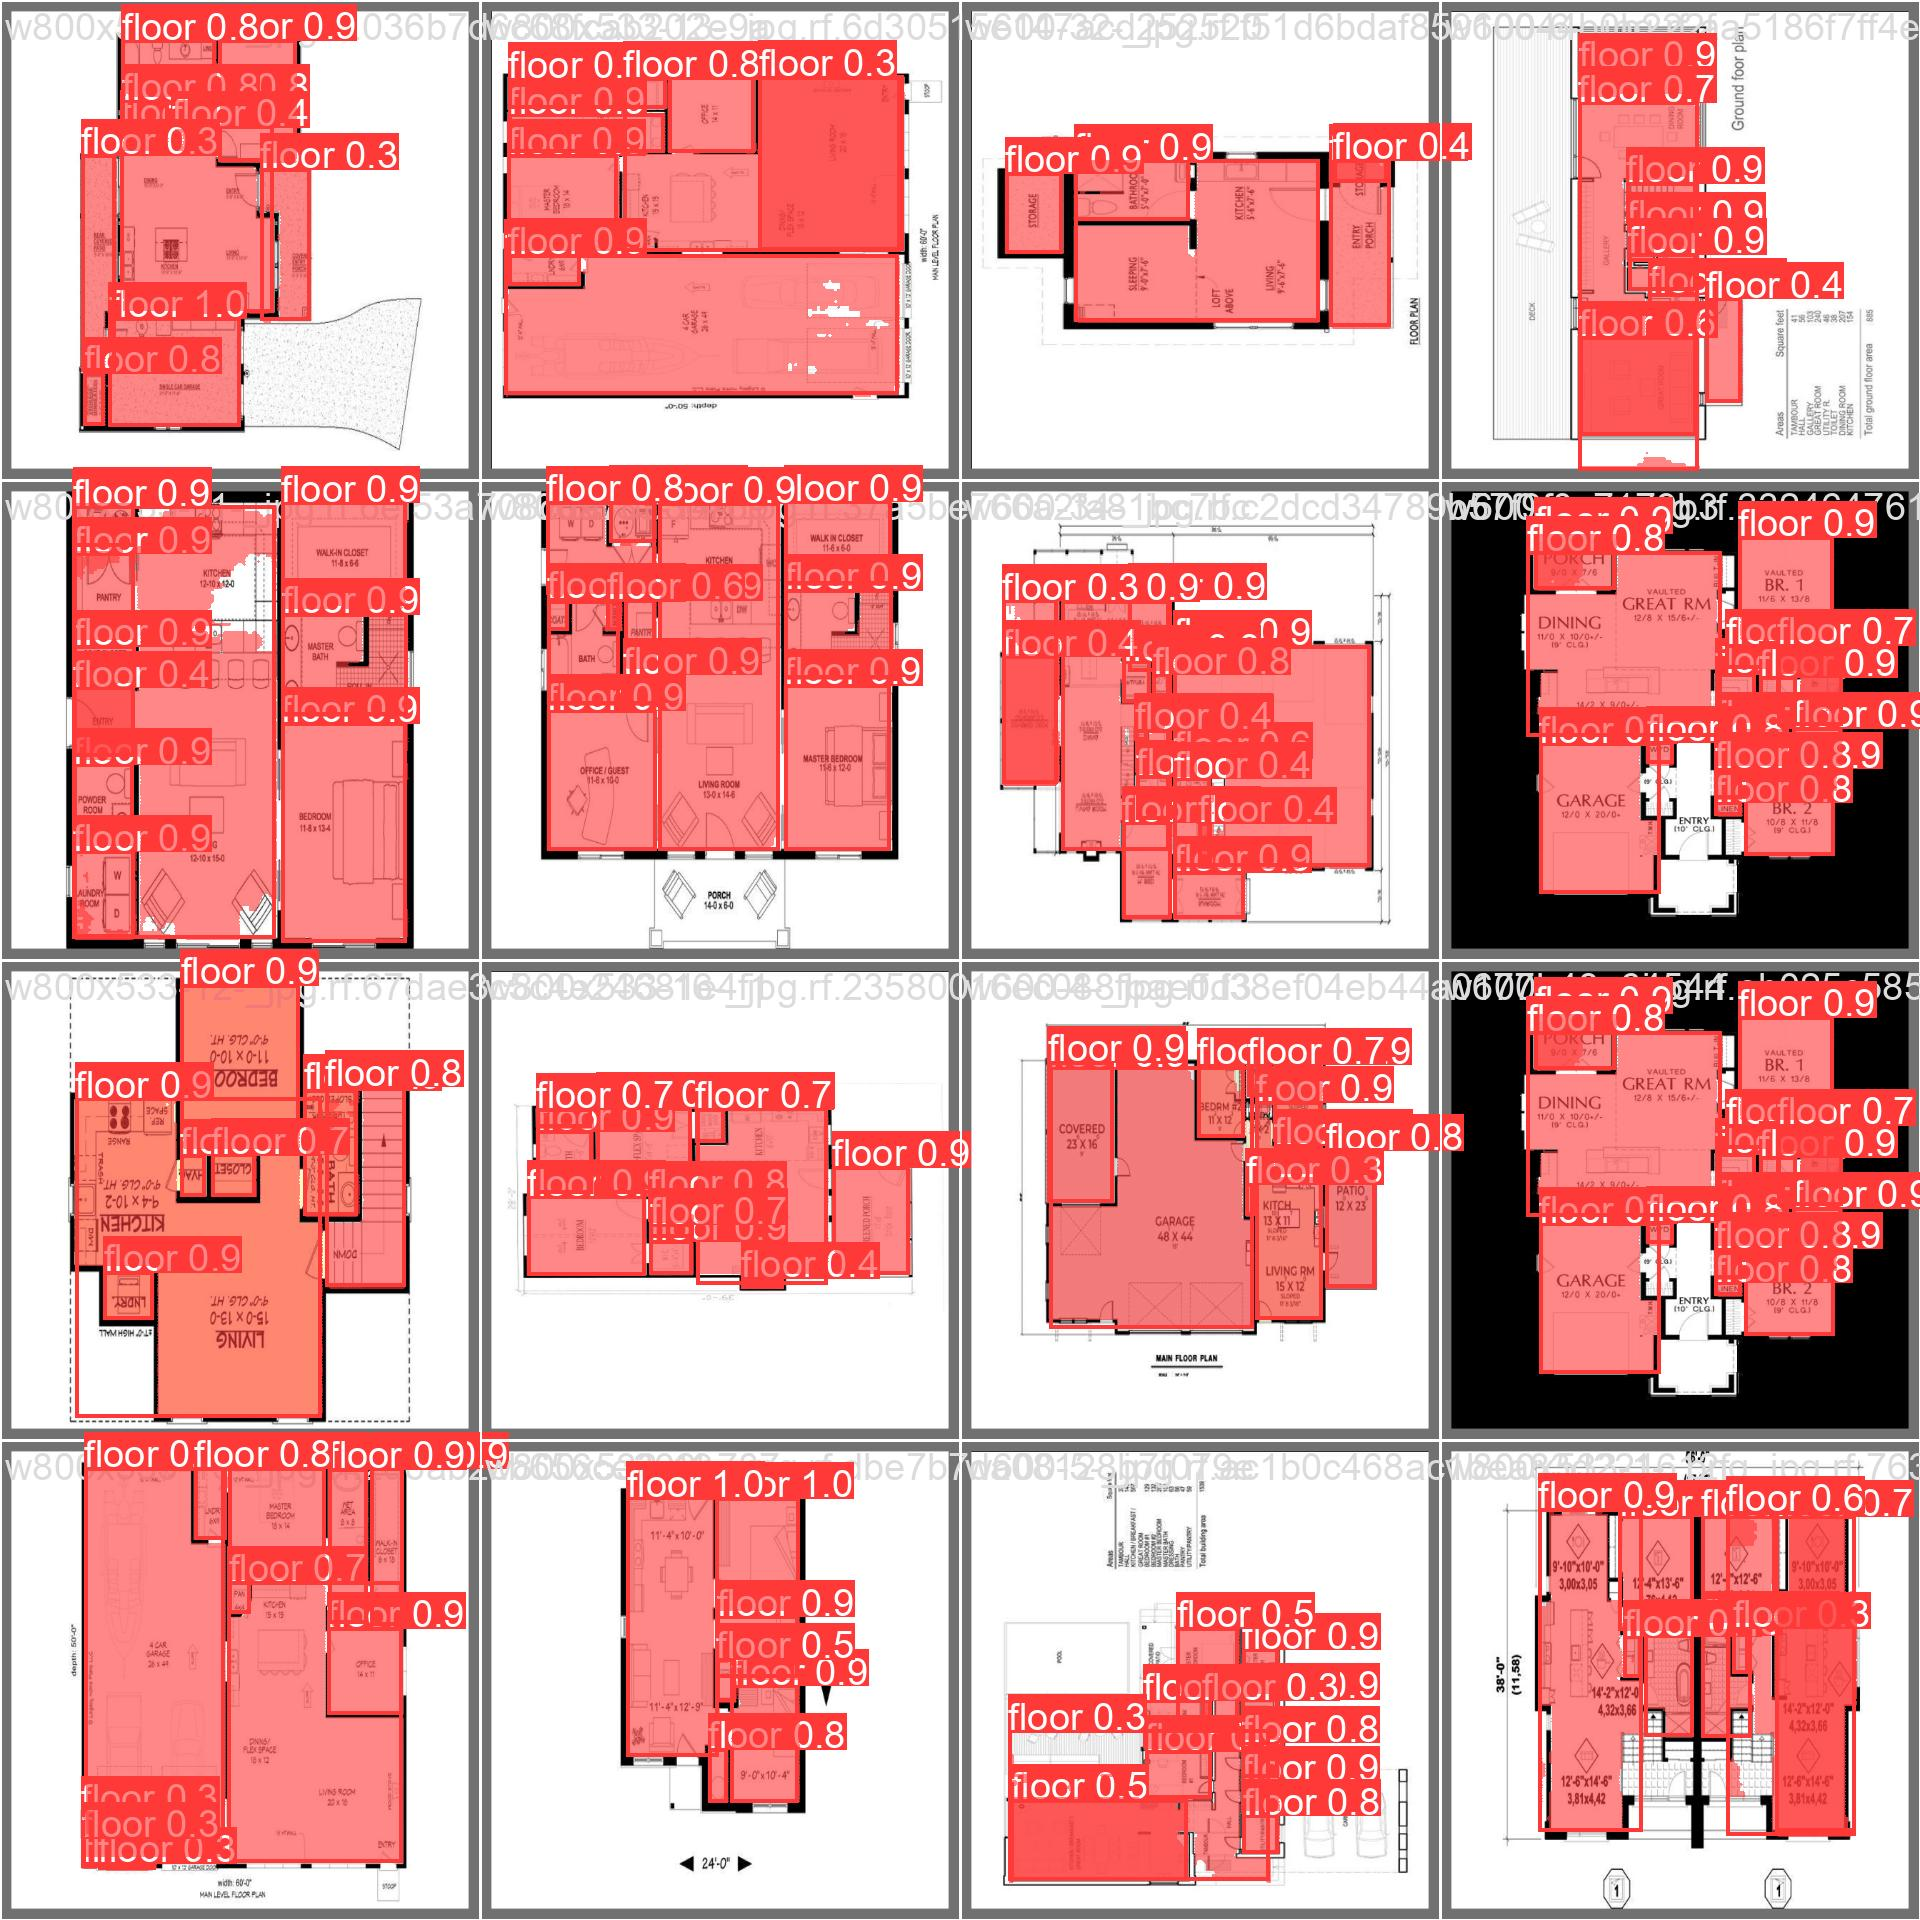

In [23]:
Image(filename=f'./runs/segment/train2/val_batch0_pred.jpg', width=600)